In [1]:
# (Conformal Prediction) Computing d values

# Get d values

import ndjson
import pandas as pd
import os
import math
import numpy as np
from numpy import linalg as LA

H = 20
o_len = 20
p_len = 20

priv = []
pred = []
pv = "test_private_"
pd = "test_pred_"

d = "d"
x_cha = "x"
y_cha = "y"
x_l = "x_LSTM"
y_l = "y_LSTM"

d_list = []
x_list = []
y_list = []
x_l_list = []
y_l_list = []

for i in range(p_len):
    priv.append(pv + str(o_len+i))
    pred.append(pd + str(o_len+i) + "/")
    d_list.append(d+str(i+o_len))
    x_list.append(x_cha+str(i+o_len))
    y_list.append(y_cha+str(i+o_len))
    x_l_list.append(x_l+str(i+o_len))
    y_l_list.append(y_l+str(i+o_len))



In [5]:
x_l_list

['x_LSTM20',
 'x_LSTM21',
 'x_LSTM22',
 'x_LSTM23',
 'x_LSTM24',
 'x_LSTM25',
 'x_LSTM26',
 'x_LSTM27',
 'x_LSTM28',
 'x_LSTM29',
 'x_LSTM30',
 'x_LSTM31',
 'x_LSTM32',
 'x_LSTM33',
 'x_LSTM34',
 'x_LSTM35',
 'x_LSTM36',
 'x_LSTM37',
 'x_LSTM38',
 'x_LSTM39']

In [ ]:

# Modify the pred_lstm and path
from sys import maxunicode

useMaxNorm = True

pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
# path = "/Users/joey/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/"
path = "/data2/mcleav/conformalRNNs/icra_2022/code/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/"

d_value = {}
x_value = {}
y_value = {}
x_l_value = {}
y_l_value = {}

for q in range(p_len):
    os.chdir(path + str(priv[q]))
    with open('orca_three_synth.ndjson', 'r') as f:
        original_data=ndjson.load(f)    
    os.chdir(path + str(pred[q])+ str(pred_lstm))
    with open('orca_three_synth.ndjson', 'r') as f:
        predict_data=ndjson.load(f)
    
    d_value[d_list[q]] = []
    x_value[x_list[q]] = []
    y_value[y_list[q]] = []
    x_l_value[x_l_list[q]] = []
    y_l_value[y_l_list[q]] = []
    
    number_of_scenes = []
    p_values = []
    s_values = []
    e_values = []
    IDs = []
    # increase if there are more pedestrian
    
    peds = ["Ped 1", "Ped 2", "Ped 3"]
    ID = "ID: "

    for i in range(len(original_data)):
        if list(original_data[i].keys())[0] == 'scene':
            number_of_scenes.append(list(original_data[i].values())[0].get("id"))

    for i in range(len(original_data)):
        if list(original_data[i].keys())[0] == 'track':
            p_values.append(list(original_data[i].values())[0].get("p"))

    p_value = []
    for i in p_values:
        if i not in p_value:
            p_value.append(i)
    
    for i in range(len(predict_data)):
        if list(predict_data[i].keys())[0] == 'scene':
            s_values.append(list(predict_data[i].values())[0].get("s"))
            e_values.append(list(predict_data[i].values())[0].get("e"))
        
    for i in range(len(number_of_scenes)):
        IDs.append(number_of_scenes[i])
        IDs[i] = ID + str(IDs[i])

    p_values_for_scene_id = {}
    for i in range(len(s_values)):
        p_values_for_scene_id[IDs[i]] = []
        p = []
        pp = []
        for j in range(len(predict_data)):
            if list(predict_data[j].keys())[0] == 'track':
                if list(predict_data[j].values())[0].get("scene_id") == number_of_scenes[i]:
                    p.append(list(predict_data[j].values())[0].get("p"))
        for k in p:
            if k not in pp:
                pp.append(k)
        p_values_for_scene_id.update({IDs[i] : pp})
    
    x_original_trajectories = {}
    y_original_trajectories = {}

    for i in range(len(s_values)):
        x_original_trajectories[IDs[i]] = {}
        y_original_trajectories[IDs[i]] = {}
        for t in range(3):
            x_original_trajectories[IDs[i]][peds[t]] = []
            y_original_trajectories[IDs[i]][peds[t]] = []   
            x_orig_traj = []
            y_orig_traj = []
            for j in range(len(original_data)):
                if list(original_data[j].keys())[0] == 'track':
                    if list(original_data[j].values())[0].get("p") == p_values_for_scene_id[IDs[i]][t]:
                        for k in range(s_values[i], e_values[i]+1):
                            if list(original_data[j].values())[0].get("f") == k:
                                x_orig_traj.append(list(original_data[j].values())[0].get("x"))
                                y_orig_traj.append(list(original_data[j].values())[0].get("y"))
            x_original_trajectories[IDs[i]].update({peds[t] : x_orig_traj})
            y_original_trajectories[IDs[i]].update({peds[t] : y_orig_traj})

    # Prediction Trajectories
    x_predict_trajectories = {}
    y_predict_trajectories = {}

    for i in range(len(s_values)):
        x_predict_trajectories[IDs[i]] = {}
        y_predict_trajectories[IDs[i]] = {}
        x_pred_traj = []
        y_pred_traj = []
        for j in range(len(predict_data)):
            if list(predict_data[j].keys())[0] == 'track':
                if list(predict_data[j].values())[0].get("scene_id") == number_of_scenes[i]:
                    x_pred_traj.append(list(predict_data[j].values())[0].get("x"))
                    y_pred_traj.append(list(predict_data[j].values())[0].get("y"))
        for t in range(3):
            x_predict_trajectories[IDs[i]][peds[t]] = []
            y_predict_trajectories[IDs[i]][peds[t]] = []
            x_predict_trajectories[IDs[i]].update({peds[t] : x_pred_traj[int(p_len)*t:int(p_len)*(t+1)]})
            y_predict_trajectories[IDs[i]].update({peds[t] : y_pred_traj[int(p_len)*t:int(p_len)*(t+1)]})

    find_th_number_x = []
    find_th_number_y = []

    for i in range(len(IDs)):
        for j in range(len(peds)):
            if not len(x_original_trajectories[IDs[i]][peds[j]]) == (q+int(o_len+p_len)):
                x_original_trajectories[IDs[i]][peds[j]] = [9999] * (q+int(o_len+p_len))
                find_th_number_x.append(np.array([i, j]))

    for i in range(len(IDs)):
        for j in range(len(peds)):
            if not len(y_original_trajectories[IDs[i]][peds[j]]) == (q+int(o_len+p_len)):
                y_original_trajectories[IDs[i]][peds[j]] = [9999] * (q+int(o_len+p_len))
                find_th_number_y.append(np.array([i, j]))
              
    for i in range(len(find_th_number_x)):
        x_predict_trajectories[IDs[find_th_number_x[i][0]]][peds[find_th_number_x[i][1]]] = [0] * 20

    for i in range(len(find_th_number_y)):
        y_predict_trajectories[IDs[find_th_number_y[i][0]]][peds[find_th_number_y[i][1]]] = [0] * 20

    R_value_x = {}
    R_value_y = {}
    R_value = {}

    list_R_value_x = []
    list_R_value_y = []
    list_R_value = []
    for i in range(len(IDs)):
        R_value_x[IDs[i]] = {}
        R_value_y[IDs[i]] = {}
        R_value[IDs[i]] = {}
        for j in range(len(peds)):
            R_value_x[IDs[i]][peds[j]] = [] 
            R_value_y[IDs[i]][peds[j]] = []
            R_value[IDs[i]][peds[j]] = []
            list_R_value_x = []
            list_R_value_y = []
            list_R_value = []
            for k in range(p_len):
                list_R_value_x.append(x_original_trajectories[IDs[i]][peds[j]][k+q+p_len] - x_predict_trajectories[IDs[i]][peds[j]][k])
                list_R_value_y.append(y_original_trajectories[IDs[i]][peds[j]][k+q+p_len] - y_predict_trajectories[IDs[i]][peds[j]][k])
                list_R_value.append(round(LA.norm([list_R_value_x[k], list_R_value_y[k]], 2), 4))
            R_value_x[IDs[i]].update({peds[j] : list_R_value_x})
            R_value_y[IDs[i]].update({peds[j] : list_R_value_y})
            R_value[IDs[i]].update({peds[j] : list_R_value})

    print("find_th_number_x length: " + str(len(find_th_number_x)))
    print("find_th_number_y length: " + str(len(find_th_number_y)))
    
    if not useMaxNorm:
        N = len(IDs) * len(peds) - len(find_th_number_x)
    else:
        N = len(IDs) - len(find_th_number_x)

    th_values = math.ceil((1+N)*(1-(0.05/H)))
    d_value_for_alpha_0_05 = []
    R = []
    numb_N = []
    numb_R = "R"

    for i in range(1,p_len+1):
        R.append(i)
        R[i-1] = numb_R + str(i)

    R_values = {}
    list_R_values = []

    for i in range(len(R)):
        R_values[R[i]] = []
        list_R_values = []

        if not useMaxNorm:
            for j in range(len(IDs)):
                for k in range(len(peds)):
                    list_R_values.append(R_value[IDs[j]][peds[k]][i])
        else:
            for j in range(len(IDs)):
                max_R = 0
                for k in range(len(peds)):
                    max_R = max(max_R, R_value[IDs[j]][peds[k]][i])
                list_R_values.append(max_R)
        list_R_values.sort()
        R_values.update({R[i]: list_R_values})
        d_value_for_alpha_0_05.append(R_values[R[i]][int(th_values)-1])
    
    d_value.update({d_list[q]: d_value_for_alpha_0_05})
    x_value.update({x_list[q]: x_original_trajectories})
    y_value.update({y_list[q]: y_original_trajectories})
    x_l_value.update({x_l_list[q]: x_predict_trajectories})
    y_l_value.update({y_l_list[q]: y_predict_trajectories})
    
    print(q)

import pickle

save_path = "/data2/mcleav/conformalRNNs/icra_2022/code/aaa/maxNorm/"
fid = open(save_path + "d_value.pkl", 'wb')
pickle.dump(d_value, fid)
fid.close()

fid = open(save_path + "x_value.pkl", 'wb')
pickle.dump(x_value, fid)
fid.close()

fid = open(save_path + "y_value.pkl", 'wb')
pickle.dump(y_value, fid)
fid.close()

fid = open(save_path + "x_l_value.pkl", 'wb')
pickle.dump(x_l_value, fid)
fid.close()

fid = open(save_path + "y_l_value.pkl", 'wb')
pickle.dump(y_l_value, fid)
fid.close()


In [2]:
import pickle

# save_path = "aaa/maxNorm/"
save_path = "/home/hardik/Desktop/Research/social-navigation/conformal_prediction/maxNorm/"


fid = open(save_path + "d_value.pkl", 'rb')
d_value= pickle.load(fid)
fid.close()

fid = open(save_path + "x_value.pkl", 'rb')
x_value = pickle.load(fid)
fid.close()


fid = open(save_path + "y_value.pkl", 'rb')
y_value = pickle.load(fid)
fid.close()



fid = open(save_path + "x_l_value.pkl", 'rb')
x_l_value = pickle.load(fid)
fid.close()

fid = open(save_path + "y_l_value.pkl", 'rb')
y_l_value = pickle.load(fid)
fid.close()



In [27]:
# pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
# path = "/data2/mcleav/conformalRNNs/icra_2022/code/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/"
# path = "/home/hardik/Research/social-navigation/conformal_prediction"
path = "/home/hardik/Desktop/Research/social-navigation/conformal_prediction/dataForShuo/lstm_goals_social_None_20_2000_modes1"

# (Conformal Prediction) Find an ID, Ped Numbers

# Pedestrian 1
Spec_ID_1 = []

# Modify numbers
x_H10_1 = []
y_H10_1 = []
d_20_1 = []

# os.chdir(path + str(pred[0])+ str(pred_lstm))
os.chdir(path)
with open('orca_three_synth.ndjson', 'r') as f:
    predict_data=ndjson.load(f)

s_point = 104533
p_point = 3617
Spec_ID_1.append(1997)

x_H10_1.append(x_l_value[x_l_list[0]]['ID: '+str(Spec_ID_1[0])]['Ped 1'])
y_H10_1.append(y_l_value[y_l_list[0]]['ID: '+str(Spec_ID_1[0])]['Ped 1'])
d_20_1.append(d_value[d_list[0]])

for q in range(1, p_len):
    # os.chdir(path + str(pred[q])+ str(pred_lstm))
    os.chdir(path)
    with open('orca_three_synth.ndjson', 'r') as f:
        predict_data=ndjson.load(f)
    
    for i in range(len(predict_data)):
        if list(predict_data[i].keys())[0] == 'scene':
            if list(predict_data[i].values())[0].get("s") == s_point:
                if list(predict_data[i].values())[0].get("p") == p_point:
                    Spec_ID_1.append(predict_data[i]['scene']['id'])
    print(f"q:{q}, x_l_list: {x_l_list[q]}, specs:{Spec_ID_1}")
    x_H10_1.append(x_l_value[x_l_list[q]]['ID: '+str(Spec_ID_1[q])]['Ped 1'])
    y_H10_1.append(y_l_value[y_l_list[q]]['ID: '+str(Spec_ID_1[q])]['Ped 1'])
    d_20_1.append(d_value[d_list[q]])
    
original_x_1 = x_value[x_list[0]]['ID: '+str(1997)]['Ped 1']
original_y_1 = y_value[y_list[0]]['ID: '+str(1997)]['Ped 1']

# %cd /Users/joey

q:1, x_l_list: x_LSTM21, specs:[1997, 1997]


KeyError: 'ID: 1997'

In [25]:
x_l_value['x_LSTM21']#['ID: 1997']
# x_l_value[x_l_list[q]]['ID: '+str(Spec_ID_1[q])]
# x_l_value['x_LSTM21']['ID: '+str(Spec_ID_1[q])]['Ped 1']\
# x_l_list[q]

{'ID: 2010': {'Ped 1': [-1.1,
   -1.01,
   -0.92,
   -0.83,
   -0.74,
   -0.66,
   -0.57,
   -0.48,
   -0.39,
   -0.3,
   -0.21,
   -0.12,
   -0.03,
   0.05,
   0.14,
   0.23,
   0.32,
   0.41,
   0.5,
   0.58],
  'Ped 2': [-1.76,
   -1.7,
   -1.62,
   -1.56,
   -1.49,
   -1.42,
   -1.35,
   -1.29,
   -1.22,
   -1.15,
   -1.08,
   -1.02,
   -0.95,
   -0.88,
   -0.82,
   -0.75,
   -0.68,
   -0.61,
   -0.54,
   -0.47],
  'Ped 3': [-0.42,
   -0.41,
   -0.39,
   -0.37,
   -0.36,
   -0.34,
   -0.33,
   -0.31,
   -0.29,
   -0.27,
   -0.26,
   -0.24,
   -0.22,
   -0.2,
   -0.18,
   -0.16,
   -0.14,
   -0.12,
   -0.11,
   -0.09]},
 'ID: 2011': {'Ped 1': [-1.76,
   -1.7,
   -1.63,
   -1.56,
   -1.49,
   -1.42,
   -1.36,
   -1.29,
   -1.22,
   -1.15,
   -1.09,
   -1.02,
   -0.95,
   -0.88,
   -0.82,
   -0.75,
   -0.68,
   -0.61,
   -0.54,
   -0.47],
  'Ped 2': [-1.1,
   -1.01,
   -0.92,
   -0.83,
   -0.74,
   -0.65,
   -0.56,
   -0.48,
   -0.39,
   -0.3,
   -0.21,
   -0.12,
   -0.03,
   0.05,
  

In [7]:
pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
path = "/data2/mcleav/conformalRNNs/icra_2022/code/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/"


# (Conformal Prediction) Find an ID, Ped Numbers

# Pedestrian 2
Spec_ID_2 = []

# Modify numbers
x_H10_2 = []
y_H10_2 = []
d_20_2 = []

os.chdir(path + str(pred[0])+ str(pred_lstm))
with open('orca_three_synth.ndjson', 'r') as f:
    predict_data=ndjson.load(f)

s_point = 104162
p_point = 3605
Spec_ID_2.append(1994)

x_H10_2.append(x_l_value[x_l_list[0]]['ID: '+str(Spec_ID_2[0])]['Ped 1'])
y_H10_2.append(y_l_value[y_l_list[0]]['ID: '+str(Spec_ID_2[0])]['Ped 1'])
d_20_2.append(d_value[d_list[0]])

for q in range(1, p_len):
    os.chdir(path + str(pred[q])+ str(pred_lstm))
    with open('orca_three_synth.ndjson', 'r') as f:
        predict_data=ndjson.load(f)
    
    for i in range(len(predict_data)):
        if list(predict_data[i].keys())[0] == 'scene':
            if list(predict_data[i].values())[0].get("s") == s_point:
                if list(predict_data[i].values())[0].get("p") == p_point:
                    Spec_ID_2.append(predict_data[i]['scene']['id'])
    
    x_H10_2.append(x_l_value[x_l_list[q]]['ID: '+str(Spec_ID_2[q])]['Ped 1'])
    y_H10_2.append(y_l_value[y_l_list[q]]['ID: '+str(Spec_ID_2[q])]['Ped 1'])
    d_20_2.append(d_value[d_list[q]])
    
original_x_2 = x_value[x_list[0]]['ID: '+str(1994)]['Ped 1']
original_y_2 = y_value[y_list[0]]['ID: '+str(1994)]['Ped 1']

# %cd /Users/joey

In [8]:
pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
path = "/data2/mcleav/conformalRNNs/icra_2022/code/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/"


# (Conformal Prediction) Find an ID, Ped Numbers

# Pedestrian 3
Spec_ID_3 = []

# Modify numbers
x_H10_3 = []
y_H10_3 = []
d_20_3 = []

os.chdir(path + str(pred[0])+ str(pred_lstm))
with open('orca_three_synth.ndjson', 'r') as f:
    predict_data=ndjson.load(f)

s_point = 111117
p_point = 3850
Spec_ID_3.append(2125)

x_H10_3.append(x_l_value[x_l_list[0]]['ID: '+str(Spec_ID_3[0])]['Ped 1'])
y_H10_3.append(y_l_value[y_l_list[0]]['ID: '+str(Spec_ID_3[0])]['Ped 1'])
d_20_3.append(d_value[d_list[0]])

for q in range(1, p_len):
    os.chdir(path + str(pred[q])+ str(pred_lstm))
    with open('orca_three_synth.ndjson', 'r') as f:
        predict_data=ndjson.load(f)
    
    for i in range(len(predict_data)):
        if list(predict_data[i].keys())[0] == 'scene':
            if list(predict_data[i].values())[0].get("s") == s_point:
                if list(predict_data[i].values())[0].get("p") == p_point:
                    Spec_ID_3.append(predict_data[i]['scene']['id'])
    
    x_H10_3.append(x_l_value[x_l_list[q]]['ID: '+str(Spec_ID_3[q])]['Ped 1'])
    y_H10_3.append(y_l_value[y_l_list[q]]['ID: '+str(Spec_ID_3[q])]['Ped 1'])
    d_20_3.append(d_value[d_list[q]])
    
original_x_3 = x_value[x_list[0]]['ID: '+str(2125)]['Ped 1']
original_y_3 = y_value[y_list[0]]['ID: '+str(2125)]['Ped 1']

# %cd /Users/joey

In [ ]:
pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
path = "/data2/mcleav/conformalRNNs/icra_2022/code/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/"


# Open-loop MPC

# One Pedestrian with Dynamic
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ImageMagickWriter
from casadi import *

opti = casadi.Opti()

predict_x1 = x_H10_1[0]
predict_y1 = y_H10_1[0]
d20_value_H20_1 = d_20_1[0]

eps = 0.2

T = 20

Delta = 1/10
L = 1

predict_x1 = original_x_1[0:T] + predict_x1
predict_y1 = original_y_1[0:T] + predict_y1

x_state = [0]*(T-1)
y_state = [-2]*(T-1)

xref = 0
yref = 2

x = opti.variable(T)
y = opti.variable(T)
V = opti.variable(T)
theta = opti.variable(T)

uv = opti.variable(T)
delta = opti.variable(T)

opti.set_initial(x[0], x_state[0])
opti.set_initial(y[0], y_state[0])
opti.set_initial(V[0], 1)
opti.set_initial(theta[0], pi)

p_opts = {"expand":True}
s_opts = {"max_iter": 3000}
opti.solver('ipopt', p_opts, s_opts)

obj = 0
for i in range(1, T):
    #opti.subject_to(opti.bounded(-3, V[i], 3))
    opti.subject_to(opti.bounded(-pi/6, delta[i], pi/6))
    #opti.subject_to(opti.bounded(-3, uv[i], 3))
    opti.subject_to(x[i] == x[i-1] + Delta * (V[i-1]*cos(theta[i-1])))
    opti.subject_to(y[i] == y[i-1] + Delta * (V[i-1]*sin(theta[i-1])))
    opti.subject_to(theta[i] == theta[i-1] + Delta * (V[i-1]/L*tan(delta[i-1])))
    opti.subject_to(V[i] == V[i-1] + Delta*(uv[i-1]))
    
for i in range(T):
    obj += delta[i-1]**2 + uv[i-1]**2
    opti.minimize(obj)
    opti.subject_to(sqrt((x[i]-predict_x1[i+T])**2+(y[i]-predict_y1[i+T])**2) >= d20_value_H20_1[i]+eps)
    
opti.subject_to(x[0]-x_state[0] == 0)
opti.subject_to(y[0]-y_state[0] == 0)
opti.subject_to(x[T-1]-xref == 0)
opti.subject_to(y[T-1]-yref == 0)

sol = opti.solve()

x_state = x_state + list(sol.value(x)) + [list(sol.value(x))[T-1]]
y_state = y_state + list(sol.value(y)) + [list(sol.value(y))[T-1]]

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
axis = plt.axes(xlim =(-3.5, 1.5),
            ylim =(-2.5, 2.5))
ts = np.linspace(0,2*pi,100)

p1_line, = axis.plot([], [], '*', color = 'k', markersize = 15)
r_line, = axis.plot([], [], 'v', color = 'k', markersize = 12)
c1_line, = axis.plot([], [], '-', color = 'g')
af1_line, = axis.plot([], [], '*', color = 'r')
ch1_line, = axis.plot([], [], color = 'k')

arrow = axis.annotate("", xy=(2, 2), xytext=(0, 0), arrowprops={"facecolor": "black"})

x_robot, y_robot = [], []
x_pred1, y_pred1 = [], []
x1_circle, y1_circle = [], []
x_af1, y_af1 = [], []

def init(): 
    p1_line.set_data([], [])
    r_line.set_data([], [])
    c1_line.set_data([], [])
    af1_line.set_data([], [])
    ch1_line.set_data([], [])
    return p1_line, r_line, c1_line, af1_line, ch1_line,

def animate(i):
    global arrow
    if i <= 19:
        x_r = x_state[i]
        y_r = y_state[i]
        x_robot.append(x_r)
        y_robot.append(y_r)
        r_line.set_data(x_robot, y_robot)
    
    if i >= 20:
        arrow = axis.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops={"facecolor": "black"})
        center = np.array([x_state[i], y_state[i]])
        arrow.xy = center + ((x_state[i] - x_state[i-1])/5, (y_state[i] - y_state[i-1])/5)
        arrow.set_position(center)
    
    x_pred1, y_pred1 = [], []
    x_p1 = original_x_1[i]
    y_p1 = original_y_1[i]
    x_pred1.append(x_p1)
    y_pred1.append(y_p1)
    p1_line.set_data(x_pred1, y_pred1)
    
    x_af1, y_af1 = [], []
    if i >= T:
        x_a1 = predict_x1[T:T+T]
        y_a1 = predict_y1[T:T+T]
        x_af1 = x_af1 + x_a1
        y_af1 = y_af1 + y_a1
        af1_line.set_data(x_af1, y_af1)
        
    x1_circle, y1_circle = [], []
    if i >= T:
        for j in range(T):
            c_x1 = d20_value_H20_1[j] * np.cos(ts) + predict_x1[T+j]
            c_y1 = d20_value_H20_1[j] * np.sin(ts) + predict_y1[T+j]
            x1_circle.append(c_x1)
            y1_circle.append(c_y1)
            c1_line.set_data(x1_circle, y1_circle)
    
    xh1_circle, yh1_circle = [], []

    if i >= T:
        ch_x1 = d20_value_H20_1[i-T] * np.cos(ts) + predict_x1[i]
        ch_y1 = d20_value_H20_1[i-T] * np.sin(ts) + predict_y1[i]
        xh1_circle.append(ch_x1)
        yh1_circle.append(ch_y1)
        ch1_line.set_data(xh1_circle, yh1_circle)
    return p1_line, r_line, c1_line, af1_line, ch1_line, arrow

plt.legend(['Current_Obstacle_1', 'Robot', 'Safe_Area_1', 
            'Predicted_Obstacle_1', 'Current_Safe_Area_1'], fontsize = 10)

plt.xlabel('Position x')
plt.ylabel('Position y')
plt.title("Open-loop")

anim = FuncAnimation(fig, animate, init_func = init, frames=T+20, blit=True)
gif_writer = ImageMagickWriter(fps=2)
anim.save('/data2/mcleav/conformalRNNs/icra_2022/code/open_mpc_dynamic_one_Ped.gif', writer=gif_writer)

In [ ]:
pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
path = "/data2/mcleav/conformalRNNs/icra_2022/code/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/"


# Closed-loop MPC

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ImageMagickWriter
from casadi import *

opti = casadi.Opti()

eps = 0.2
L = 1
Delta = 1/10
T = 20
H = 20

for i in range(T):
    x_H10_1[i] = original_x_1[0:T] + x_H10_1[i]
    y_H10_1[i] = original_y_1[0:T] + y_H10_1[i]

x_state = [0]*T
y_state = [-2]*T

x_current = 0
y_current = -2

xref = 0
yref = 2

x = opti.variable(T)
y = opti.variable(T)
V = opti.variable(T)
theta = opti.variable(T)
uv = opti.variable(T)
delta = opti.variable(T)

opti.set_initial(x[0], x_state[0])
opti.set_initial(y[0], y_state[0])
opti.set_initial(V[0], 1)
opti.set_initial(theta[0], pi)

p_opts = {"expand":True}
s_opts = {"max_iter": 3000}
opti.solver('ipopt', p_opts, s_opts)

for t in range(T):
    obj = 0
    for i in range(1, T):
        #opti.subject_to(opti.bounded(0, V[i], 3))
        opti.subject_to(opti.bounded(-pi/6, delta[i], pi/6))
        #opti.subject_to(opti.bounded(-3, uv[i], 3))
        opti.subject_to(x[i] == x[i-1] + Delta * (V[i-1]*cos(theta[i-1])))
        opti.subject_to(y[i] == y[i-1] + Delta * (V[i-1]*sin(theta[i-1])))
        opti.subject_to(theta[i] == theta[i-1] + Delta * (V[i-1]/L*tan(delta[i-1])))
        opti.subject_to(V[i] == V[i-1] + Delta*(uv[i-1]))
        
        obj += delta[i-1]**2 + uv[i-1]**2
        opti.minimize(obj)
        
    for tau in range(H):
        opti.subject_to(sqrt((x[tau]-x_H10_1[t][T+tau])**2+(y[tau]-y_H10_1[t][T+tau])**2) >= d_20_1[t][tau]+eps)
            
    opti.subject_to(x[0]-x_current == 0)
    opti.subject_to(y[0]-y_current == 0)
    opti.subject_to(x[T-t-1]-xref == 0)
    opti.subject_to(y[T-t-1]-yref == 0)

    sol = opti.solve()

    x_current = sol.value(x)[1]
    y_current = sol.value(y)[1]
    
    x_state.append(x_current)
    y_state.append(y_current)
    
    x = opti.variable(T)
    y = opti.variable(T)
    V = opti.variable(T)
    theta = opti.variable(T)

    uv = opti.variable(T)
    delta = opti.variable(T)
    
    opti.set_initial(x[0], x_current)
    opti.set_initial(y[0], y_current)
    
fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
axis = plt.axes(xlim =(-3.5, 1.5),
            ylim =(-2.5, 2.5))
ts = np.linspace(0,2*pi,100)

p_line, = axis.plot([], [], '*', markersize = 15)
r_line, = axis.plot([], [], 'v', color = 'k', markersize = 12)
c_line, = axis.plot([], [], color = 'g')
af_line, = axis.plot([], [], '*', color = 'r')

arrow = axis.annotate("", xy=(2, 2), xytext=(0, 0), arrowprops={"facecolor": "black"})

x_robot, y_robot = [], []
x_pred, y_pred = [], []
x_circle, y_circle = [], []
x_af, y_af = [], []
ch_line, = axis.plot([], [], color = 'k')

def init(): 
    p_line.set_data([], [])
    c_line.set_data([], [])
    r_line.set_data([], [])
    af_line.set_data([], [])
    ch_line.set_data([], [])
    return p_line, r_line, c_line, af_line, ch_line,

def animate(i):
    global arrow
    if i <= 19:
        x_r = x_state[i]
        y_r = y_state[i]
        x_robot.append(x_r)
        y_robot.append(y_r)
        r_line.set_data(x_robot, y_robot)
    
    if i >= 20:
        arrow = axis.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops={"facecolor": "black"})
        center = np.array([x_state[i], y_state[i]])
        arrow.xy = center + ((x_state[i] - x_state[i-1])/5, (y_state[i] - y_state[i-1])/5)
        arrow.set_position(center)
    
    x_pred, y_pred = [], []
    if i >= T:
        x_p = x_H10_1[i-T][T]
        y_p = y_H10_1[i-T][T]
        x_pred.append(x_p)
        y_pred.append(y_p)
        p_line.set_data(x_pred, y_pred)
    elif i <= T-1:
        x_p = x_H10_1[0][i]
        y_p = y_H10_1[0][i]
        x_pred.append(x_p)
        y_pred.append(y_p)
        p_line.set_data(x_pred, y_pred)

    x_af, y_af = [], []
    if T <= i <= T+T-1:
        for j in range(T+T-i):
            x_a = x_H10_1[i-T][T+j]
            y_a = y_H10_1[i-T][T+j]
            x_af.append(x_a)
            y_af.append(y_a)
            af_line.set_data(x_af, y_af)
    #if T <= i <= T+10-1:
    #    for j in range(H):
    #        x_a = x_H10_1[i-T][T+j]
    #        y_a = y_H10_1[i-T][T+j]
    #        x_af.append(x_a)
    #        y_af.append(y_a)
    #        af_line.set_data(x_af, y_af)
            
    x_circle, y_circle = [], []
    if T <= i <= T+T-1:
        for j in range(T+T-i):
            c_x = d_20_1[i-T][j] * np.cos(ts) + x_H10_1[i-T][T+j]
            c_y = d_20_1[i-T][j] * np.sin(ts) + y_H10_1[i-T][T+j]
            x_circle.append(c_x)
            y_circle.append(c_y)
            c_line.set_data(x_circle, y_circle)
    #if T <= i <= T+10-1:
    #    for j in range(H):
    #        c_x = d_20_1[i-T][j] * np.cos(ts) + x_H10_1[i-T][T+j]
    #        c_y = d_20_1[i-T][j] * np.sin(ts) + y_H10_1[i-T][T+j]
    #        x_circle.append(c_x)
    #        y_circle.append(c_y)
    #        c_line.set_data(x_circle, y_circle)
            
    xh_circle, yh_circle = [], []
    if i >= T:
        ch_x = d_20_1[i-T][0] * np.cos(ts) + x_H10_1[i-T][T]
        ch_y = d_20_1[i-T][0] * np.sin(ts) + y_H10_1[i-T][T]
        xh_circle.append(ch_x)
        yh_circle.append(ch_y)
        ch_line.set_data(xh_circle, yh_circle)
    return p_line, r_line, c_line, af_line, ch_line, arrow

plt.legend(['Current Obstacle', 'Robot', 'Safe_Area', 'Predicted Obstacle', 'Current_Safe_Area'], fontsize = 12)
plt.xlabel('Position x')
plt.ylabel('Position y')
plt.title("Closed-loop")

anim = FuncAnimation(fig, animate, init_func = init, frames=T+20, blit=True)
gif_writer = ImageMagickWriter(fps=2)
anim.save('closed_mpc_dynamic_one_ped.gif', writer=gif_writer)

20
20
Pred x1: [-3.41, -3.31, -3.21, -3.11, -3.01, -2.91, -2.81, -2.71, -2.61, -2.51, -2.41, -2.31, -2.21, -2.11, -2.01, -1.91, -1.81, -1.71, -1.61, -1.51, -1.41, -1.31, -1.21, -1.11, -1.01, -0.91, -0.81, -0.71, -0.61, -0.51, -0.4, -0.3, -0.2, -0.1, -0.0, 0.1, 0.2, 0.3, 0.4, 0.51]
Pred y1: [0.55, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5, 0.49, 0.49, 0.48, 0.47, 0.46, 0.45, 0.44, 0.43, 0.43, 0.42, 0.41, 0.4, 0.39, 0.38, 0.37, 0.36, 0.35, 0.34, 0.33, 0.32, 0.32, 0.31, 0.3, 0.3, 0.29, 0.28, 0.28, 0.27, 0.26, 0.25, 0.25, 0.23, 0.22]
D1: [0.0316, 0.0583, 0.1118, 0.1676, 0.2059, 0.25, 0.2816, 0.3036, 0.3353, 0.3574, 0.3795, 0.3985, 0.4206, 0.4427, 0.4617, 0.4838, 0.53, 0.5852, 0.6351, 0.6768]
Pred x2: [3.4, 3.3, 3.2, 3.1, 3.0, 2.9, 2.81, 2.71, 2.61, 2.51, 2.41, 2.31, 2.21, 2.11, 2.01, 1.91, 1.81, 1.71, 1.61, 1.51, 1.41, 1.31, 1.22, 1.12, 1.02, 0.92, 0.83, 0.73, 0.63, 0.53, 0.44, 0.34, 0.24, 0.14, 0.04, -0.06, -0.16, -0.26, -0.36, -0.46]
Pred y2: [0.15, 0.14, 0.13, 0.13, 0.12, 0.11, 0.11, 0.1, 0.1, 

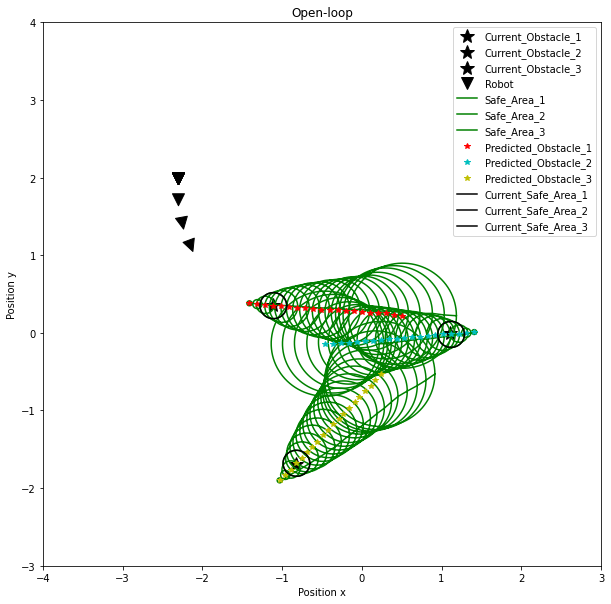

In [15]:
pred_lstm = 'lstm_goals_social_None_20_2000_modes1/'
path = "/data2/mcleav/conformalRNNs/icra_2022/code/Trajnet_test/trajnetplusplusbaselines/DATA_BLOCK/synth_data/"


# Open-loop MPC

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ImageMagickWriter
from casadi import *
import imageio

opti = casadi.Opti()

predict_x1 = x_H10_1[0]
predict_y1 = y_H10_1[0]

print(len(predict_x1))
print(len(predict_y1))


predict_x2 = x_H10_2[0]
predict_y2 = y_H10_2[0]

predict_x3 = x_H10_3[0]
predict_y3 = y_H10_3[0]

d20_value_H20_1 = d_20_1[0]
d20_value_H20_2 = d_20_2[0]
d20_value_H20_3 = d_20_3[0]


T = 20
eps = 0
Delta = 1/8
L = 1

x_state = [-2.3]*(T-1)
y_state = [2]*(T-1)
v_state = [1]*(T-1)
theta_state = [0]*(T-1)
uv_state = [0]*(T-1)
delta_state = [0]*(T-1)

xref = 0.9
yref = -2.2

predict_x1 = original_x_1[0:T] + predict_x1
predict_y1 = original_y_1[0:T] + predict_y1

predict_x2 = original_x_2[0:T] + predict_x2
predict_y2 = original_y_2[0:T] + predict_y2

predict_x3 = original_x_3[0:T] + predict_x3
predict_y3 = original_y_3[0:T] + predict_y3

print("Pred x1: " + str(predict_x1))
print("Pred y1: " + str(predict_y1))
print("D1: " + str(d20_value_H20_1))

print("Pred x2: " + str(predict_x2))
print("Pred y2: " + str(predict_y2))
print("D2: " + str(d20_value_H20_2))

print("Pred x3: " + str(predict_x3))
print("Pred y3: " + str(predict_y3))
print("D3: " + str(d20_value_H20_3))


print("d vals")
print(d20_value_H20_1)
print(d20_value_H20_2)
print(d20_value_H20_3)


x = opti.variable(T)
y = opti.variable(T)
V = opti.variable(T)
theta = opti.variable(T)

uv = opti.variable(T)
delta = opti.variable(T)

opti.subject_to(x[0]-x_state[0] == 0)
opti.subject_to(y[0]-y_state[0] == 0)
opti.subject_to(V[0] == 0)
opti.subject_to(theta[0] == -pi/2)


opti.set_initial(x[0], x_state[0])
opti.set_initial(y[0], y_state[0])
opti.set_initial(V[0], 1)
opti.set_initial(theta[0], -pi/2)

p_opts = {"expand":True}
s_opts = {"max_iter": 3000}
opti.solver('ipopt', p_opts, s_opts)

obj = 0

opti.subject_to(opti.bounded(-pi/6, delta[0], pi/6))
opti.subject_to(opti.bounded(-20, uv[0], 20))
for i in range(1, T):
    opti.subject_to(opti.bounded(0, V[i], 100))
    opti.subject_to(opti.bounded(-pi/6, delta[i], pi/6))
    opti.subject_to(opti.bounded(-20, uv[i], 20))
    
    opti.subject_to(x[i] == x[i-1] + Delta * (V[i-1]*cos(theta[i-1])))
    opti.subject_to(y[i] == y[i-1] + Delta * (V[i-1]*sin(theta[i-1])))
    opti.subject_to(theta[i] == theta[i-1] + Delta * (V[i-1]/L*tan(delta[i-1])))
    opti.subject_to(V[i] == V[i-1] + Delta*(uv[i-1]))
    
for i in range(T):
    # obj += (4*delta[i-1])**2 + uv[i-1]**2
    # obj += uv[i-1]**2
    obj += V[i]**2

    opti.subject_to(sqrt((x[i]-predict_x1[i+T])**2+(y[i]-predict_y1[i+T])**2) >= d20_value_H20_1[i]+eps)
    opti.subject_to(sqrt((x[i]-predict_x2[i+T])**2+(y[i]-predict_y2[i+T])**2) >= d20_value_H20_2[i]+eps)
    opti.subject_to(sqrt((x[i]-predict_x3[i+T])**2+(y[i]-predict_y3[i+T])**2) >= d20_value_H20_3[i]+eps)

print("Obst 1 x,y,d")
print(predict_x1)
print(predict_y1)
print(d20_value_H20_1)

print("Obst 2 x,y,d")
print(predict_x2)
print(predict_y2)
print(d20_value_H20_2)

print("Obst 1 x,y,d")
print(predict_x3)
print(predict_y3)
print(d20_value_H20_3)

opti.minimize(obj)

# obj += V[T]**2

# opti.subject_to(x[T-1]-xref == 0)
# opti.subject_to(y[T-1]-yref == 0)
opti.subject_to((x[T-1]-xref)**2 + (y[T-1]-yref)**2 <= 0.4**2)
# opti.subject_to(V[T-1]**2 <= 0.5)

sol = opti.solve()

print("Obj value: " + str(sol.value(obj)))

x_state = x_state + list(sol.value(x)) + [list(sol.value(x))[T-1]]
y_state = y_state + list(sol.value(y)) + [list(sol.value(y))[T-1]]
v_state = v_state + list(sol.value(V)) + [list(sol.value(V))[T-1]]
theta_state = theta_state + list(sol.value(theta)) + [list(sol.value(theta))[T-1]]
uv_state = uv_state + list(sol.value(uv)) + [list(sol.value(theta))[T-1]]
delta_state = delta_state + list(sol.value(delta)) + [list(sol.value(delta))[T-1]]

print("x_states: " + str(x_state))
print("y_states: " + str(y_state))
print("v_states: " + str(v_state))
print("theta_states: " + str(theta_state))
print("uv_states: " + str(uv_state))
print("delta_states: " + str(delta_state))

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
axis = plt.axes(xlim =(-4, 3),
            ylim =(-3, 4))

ts = np.linspace(0,2*pi,100)

arrow = axis.annotate("", xy=(0, 0), xytext=(0, 0), arrowprops={"facecolor": "black"})

p1_line, = axis.plot([], [], '*', color = 'k', markersize = 15)
p2_line, = axis.plot([], [], '*', color = 'k', markersize = 15)
p3_line, = axis.plot([], [], '*', color = 'k', markersize = 15)

r_line, = axis.plot([], [], 'v', color = 'k', markersize = 12)

c1_line, = axis.plot([], [], '-', color = 'g')
c2_line, = axis.plot([], [], '-', color = 'g')
c3_line, = axis.plot([], [], '-', color = 'g')

af1_line, = axis.plot([], [], '*', color = 'r')
af2_line, = axis.plot([], [], '*', color = 'c')
af3_line, = axis.plot([], [], '*', color = 'y')

ch1_line, = axis.plot([], [], color = 'k')
ch2_line, = axis.plot([], [], color = 'k')
ch3_line, = axis.plot([], [], color = 'k')

x_robot, y_robot = [], []

x_pred1, y_pred1 = [], []
x_pred2, y_pred2 = [], []
x_pred3, y_pred3 = [], []

x1_circle, y1_circle = [], []
x2_circle, y2_circle = [], []
x3_circle, y3_circle = [], []

x_af1, y_af1 = [], []
x_af2, y_af2 = [], []
x_af3, y_af3 = [], []

def init(): 
    p1_line.set_data([], [])
    p2_line.set_data([], [])
    p3_line.set_data([], [])
    
    r_line.set_data([], [])
    
    c1_line.set_data([], [])
    c2_line.set_data([], [])
    c3_line.set_data([], [])
    
    af1_line.set_data([], [])
    af2_line.set_data([], [])
    af3_line.set_data([], [])
    
    ch1_line.set_data([], [])
    ch2_line.set_data([], [])
    ch3_line.set_data([], [])
    
    return p1_line, p2_line, p3_line, r_line, c1_line, c2_line, c3_line, af1_line, af2_line, af3_line, ch1_line, ch2_line, ch3_line,

def animate(i):
    global arrow
    if i <= T-1:
        x_r = x_state[i]
        y_r = y_state[i]
        x_robot.append(x_r)
        y_robot.append(y_r)
        r_line.set_data(x_robot, y_robot)
    
    if i >= T:
        arrow = axis.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops={"facecolor": "black"})
        center = np.array([x_state[i], y_state[i]])
        arrow.xy = center + ((x_state[i] - x_state[i-1])/5, (y_state[i] - y_state[i-1])/5)
        arrow.set_position(center)
    
    x_pred1, y_pred1 = [], []
    x_p1 = original_x_1[i]
    y_p1 = original_y_1[i]
    x_pred1.append(x_p1)
    y_pred1.append(y_p1)
    p1_line.set_data(x_pred1, y_pred1)
    
    x_pred2, y_pred2 = [], []
    x_p2 = original_x_2[i]
    y_p2 = original_y_2[i]
    x_pred2.append(x_p2)
    y_pred2.append(y_p2)
    p2_line.set_data(x_pred2, y_pred2)
    
    x_pred3, y_pred3 = [], []
    x_p3 = original_x_3[i]
    y_p3 = original_y_3[i]
    x_pred3.append(x_p3)
    y_pred3.append(y_p3)
    p3_line.set_data(x_pred3, y_pred3)
    
    x_af1, y_af1 = [], []
    x_af2, y_af2 = [], []
    x_af3, y_af3 = [], []
    if i >= T:
        x_a1 = predict_x1[T:T+T]
        y_a1 = predict_y1[T:T+T]
        x_af1 = x_af1 + x_a1
        y_af1 = y_af1 + y_a1
        af1_line.set_data(x_af1, y_af1)
    
        x_a2 = predict_x2[T:T+T]
        y_a2 = predict_y2[T:T+T]
        x_af2 = x_af2 + x_a2
        y_af2 = y_af2 + y_a2
        af2_line.set_data(x_af2, y_af2)
        
        x_a3 = predict_x3[T:T+T]
        y_a3 = predict_y3[T:T+T]
        x_af3 = x_af3 + x_a3
        y_af3 = y_af3 + y_a3
        af3_line.set_data(x_af3, y_af3)
        
    x1_circle, y1_circle = [], []
    x2_circle, y2_circle = [], []
    x3_circle, y3_circle = [], []
    if i >= T:
        for j in range(T):
            c_x1 = d20_value_H20_1[j] * np.cos(ts) + predict_x1[T+j]
            c_y1 = d20_value_H20_1[j] * np.sin(ts) + predict_y1[T+j]
            x1_circle.append(c_x1)
            y1_circle.append(c_y1)
            c1_line.set_data(x1_circle, y1_circle)
            
            c_x2 = d20_value_H20_2[j] * np.cos(ts) + predict_x2[T+j]
            c_y2 = d20_value_H20_2[j] * np.sin(ts) + predict_y2[T+j]
            x2_circle.append(c_x2)
            y2_circle.append(c_y2)
            c2_line.set_data(x2_circle, y2_circle)
            
            c_x3 = d20_value_H20_3[j] * np.cos(ts) + predict_x3[T+j]
            c_y3 = d20_value_H20_3[j] * np.sin(ts) + predict_y3[T+j]
            x3_circle.append(c_x3)
            y3_circle.append(c_y3)
            c3_line.set_data(x3_circle, y3_circle)
    
    xh1_circle, yh1_circle = [], []
    xh2_circle, yh2_circle = [], []
    xh3_circle, yh3_circle = [], []
    if i >= T:
        ch_x1 = d20_value_H20_1[i-T] * np.cos(ts) + predict_x1[i]
        ch_y1 = d20_value_H20_1[i-T] * np.sin(ts) + predict_y1[i]
        xh1_circle.append(ch_x1)
        yh1_circle.append(ch_y1)
        ch1_line.set_data(xh1_circle, yh1_circle)
        
        ch_x2 = d20_value_H20_2[i-T] * np.cos(ts) + predict_x2[i]
        ch_y2 = d20_value_H20_2[i-T] * np.sin(ts) + predict_y2[i]
        xh2_circle.append(ch_x2)
        yh2_circle.append(ch_y2)
        ch2_line.set_data(xh2_circle, yh2_circle)
        
        ch_x3 = d20_value_H20_3[i-T] * np.cos(ts) + predict_x3[i]
        ch_y3 = d20_value_H20_3[i-T] * np.sin(ts) + predict_y3[i]
        xh3_circle.append(ch_x3)
        yh3_circle.append(ch_y3)
        ch3_line.set_data(xh3_circle, yh3_circle)
    return p1_line, p2_line, p3_line, r_line, c1_line, c2_line, c3_line, af1_line, af2_line, af3_line, ch1_line, ch2_line, ch3_line, arrow


for i in range(T+20):
    # plt.grid()

    if i <=T+3:
        plt.legend(['Current_Obstacle_1', 'Current_Obstacle_2', 'Current_Obstacle_3', 
                    'Robot', 'Safe_Area_1', 'Safe_Area_2', 'Safe_Area_3', 'Predicted_Obstacle_1', 
                    'Predicted_Obstacle_2', 'Predicted_Obstacle_3', 'Current_Safe_Area_1', 
                    'Current_Safe_Area_2', 'Current_Safe_Area_3'], fontsize = 10)

        plt.xlabel('Position x')
        plt.ylabel('Position y')
        plt.title("Open-loop")
    else:
        break

    animate(i)

    plt.savefig("/data2/mcleav/conformalRNNs/icra_2022/code/figures/openLoop_maxNorm/fig_%02i.png" % i)

    

# anim = FuncAnimation(fig, animate, init_func = init, frames=T+20, blit=True)
# gif_writer = ImageMagickWriter(fps=2)
# anim.save('open_mpc_dynamic_three_ped.gif', writer=gif_writer)

20
40
d vals
[[0.0316, 0.0583, 0.1118, 0.1676, 0.2059, 0.25, 0.2816, 0.3036, 0.3353, 0.3574, 0.3795, 0.3985, 0.4206, 0.4427, 0.4617, 0.4838, 0.53, 0.5852, 0.6351, 0.6768], [0.0224, 0.0316, 0.0608, 0.103, 0.1476, 0.1836, 0.2247, 0.2608, 0.2968, 0.3245, 0.3551, 0.3912, 0.4327, 0.4743, 0.5108, 0.5423, 0.5701, 0.5924, 0.6239, 0.6462], [0.0224, 0.0447, 0.0806, 0.1281, 0.164, 0.2062, 0.2421, 0.278, 0.314, 0.3421, 0.3701, 0.4061, 0.4482, 0.4833, 0.5148, 0.5423, 0.5646, 0.5962, 0.6185, 0.6555], [0.0224, 0.0447, 0.0943, 0.1304, 0.1703, 0.1903, 0.23, 0.24, 0.2602, 0.2702, 0.2902, 0.3102, 0.3471, 0.3883, 0.4374, 0.4707, 0.4653, 0.4627, 0.4768, 0.4884], [0.0224, 0.05, 0.0583, 0.0943, 0.1166, 0.1389, 0.1612, 0.1836, 0.211, 0.2335, 0.2778, 0.3191, 0.3606, 0.4159, 0.4383, 0.4428, 0.4418, 0.4405, 0.4501, 0.4501], [0.02, 0.0361, 0.051, 0.0806, 0.102, 0.1204, 0.1414, 0.1655, 0.1887, 0.2335, 0.2683, 0.2941, 0.3162, 0.3245, 0.3467, 0.3551, 0.3636, 0.378, 0.414, 0.4441], [0.0224, 0.0361, 0.05, 0.0707, 0.09

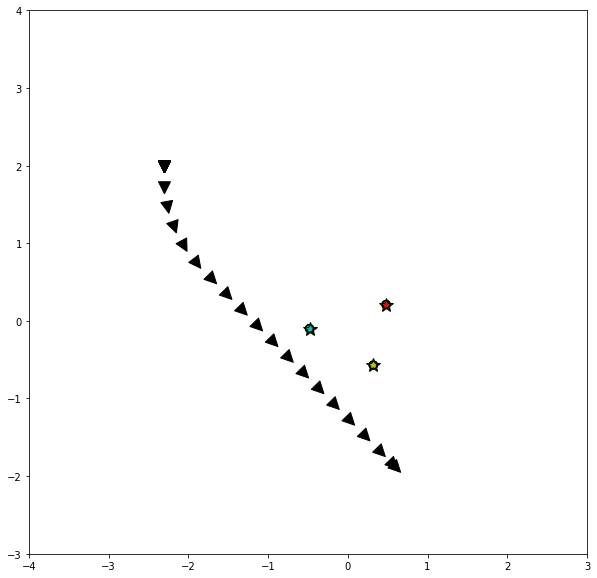

In [18]:
# Closed-loop MPC

# Dynamics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, ImageMagickWriter
from casadi import *

opti = casadi.Opti()

T = 20
H = 20
eps = 0
Delta = 1/8
L = 1


x_H10_1_cl = []
y_H10_1_cl = []
x_H10_2_cl = []
y_H10_2_cl = []
x_H10_3_cl = []
y_H10_3_cl = []

# If you run this code once, please comment the below for loop.
for i in range(T):
    x_H10_1_cl.append(original_x_1[0:T] + x_H10_1[i])
    y_H10_1_cl.append(original_y_1[0:T] + y_H10_1[i])
    x_H10_2_cl.append(original_x_2[0:T] + x_H10_2[i])
    y_H10_2_cl.append(original_y_2[0:T] + y_H10_2[i])
    x_H10_3_cl.append(original_x_3[0:T] + x_H10_3[i])
    y_H10_3_cl.append(original_y_3[0:T] + y_H10_3[i])

print(len(x_H10_1_cl))
print(len(x_H10_1_cl[0]))


print("d vals")
print(d_20_1)
print(d_20_2)
print(d_20_3)


xref = 0.9
yref = -2.2

x_state = [-2.3]*T
y_state = [2]*T
v_state = [0]*T
theta_state = [0]*T
uv_state = [0]*T
delta_state = [0]*T

x_current = -2.3
y_current = 2

x = opti.variable(T)
y = opti.variable(T)
V = opti.variable(T)
theta = opti.variable(T)

uv = opti.variable(T)
delta = opti.variable(T)

opti.subject_to(x[0] == x_current)
opti.subject_to(y[0] == y_current)
opti.subject_to(V[0] == 0)
opti.subject_to(theta[0] == -pi/2)


opti.set_initial(x[0], x_state[0])
opti.set_initial(y[0], y_state[0])
opti.set_initial(V[0], 5)
opti.set_initial(theta[0], -pi/2)

p_opts = {"expand":True}
s_opts = {"max_iter": 5000}
opti.solver('ipopt', p_opts, s_opts)

# for t in range(T):
for t in range(T):
    print("Step: " + str(t))
    obj = 0
    opti.subject_to(opti.bounded(-pi/6, delta[0], pi/6))
    opti.subject_to(opti.bounded(-20, uv[0], 20))
    
    for i in range(1, T):
        opti.subject_to(opti.bounded(0, V[i], 100))
        opti.subject_to(opti.bounded(-pi/6, delta[i], pi/6))
        opti.subject_to(opti.bounded(-20, uv[i], 20))

        opti.subject_to(x[i] == x[i-1] + Delta * (V[i-1]*cos(theta[i-1])))
        opti.subject_to(y[i] == y[i-1] + Delta * (V[i-1]*sin(theta[i-1])))
        opti.subject_to(theta[i] == theta[i-1] + Delta * (V[i-1]/L*tan(delta[i-1])))
        opti.subject_to(V[i] == V[i-1] + Delta*(uv[i-1]))
        
        # obj += uv[i-1]**2
        obj += V[i]**2

    opti.minimize(obj)
    
    for tau in range(H):
        opti.subject_to(sqrt((x[tau]-x_H10_1_cl[t][T+tau])**2+(y[tau]-y_H10_1_cl[t][T+tau])**2) >= d_20_1[t][tau]+eps)
        opti.subject_to(sqrt((x[tau]-x_H10_2_cl[t][T+tau])**2+(y[tau]-y_H10_2_cl[t][T+tau])**2) >= d_20_2[t][tau]+eps)
        opti.subject_to(sqrt((x[tau]-x_H10_3_cl[t][T+tau])**2+(y[tau]-y_H10_3_cl[t][T+tau])**2) >= d_20_3[t][tau]+eps)

    print("Obst 1 x,y,d")
    print(x_H10_1_cl[t])
    print(y_H10_1_cl[t])
    print(d_20_1[t])

    print("Obst 2 x,y,d")
    print(x_H10_2_cl[t])
    print(y_H10_2_cl[t])
    print(d_20_2[t])

    print("Obst 1 x,y,d")
    print(x_H10_3_cl[t])
    print(y_H10_3_cl[t])
    print(d_20_3[t])


    # for i in range(T):
    #     opti.subject_to(sqrt((x[i]-predict_x1[i+T])**2+(y[i]-predict_y1[i+T])**2) >= d20_value_H20_1[i]+eps)
    #     opti.subject_to(sqrt((x[i]-predict_x2[i+T])**2+(y[i]-predict_y2[i+T])**2) >= d20_value_H20_2[i]+eps)
    #     opti.subject_to(sqrt((x[i]-predict_x3[i+T])**2+(y[i]-predict_y3[i+T])**2) >= d20_value_H20_3[i]+eps)

    
    # opti.subject_to(x[T-t-1]-xref == 0)
    # opti.subject_to(y[T-t-1]-yref == 0)
    opti.subject_to((x[T-t-1]-xref)**2 + (y[T-t-1]-yref)**2 <= 0.4**2)
    # opti.subject_to(V[T-t-1] <= 1)

    sol = opti.solve()

    x_current = sol.value(x)[1]
    y_current = sol.value(y)[1]
    v_current = sol.value(V)[1]
    theta_current = sol.value(theta)[1]
    uv_current = sol.value(uv)[0]
    delta_current = sol.value(delta)[0]

    # if t == 0:
    print("Closed loop first iter soln:")
    print(sol.value(x))
    print(sol.value(y))
    print(sol.value(V))
    print(sol.value(theta))
    print(sol.value(uv))
    print(sol.value(delta))

    x_state.append(x_current)
    y_state.append(y_current)
    v_state.append(v_current)
    theta_state.append(theta_current)
    uv_state.append(uv_current)
    delta_state.append(delta_current)
    
    x = opti.variable(T)
    y = opti.variable(T)
    V = opti.variable(T)
    theta = opti.variable(T)

    uv = opti.variable(T)
    delta = opti.variable(T)
    
    opti.subject_to(x[0] == x_current)
    opti.subject_to(y[0] == y_current)
    opti.subject_to(V[0] == v_current)
    opti.subject_to(theta[0] == theta_current)


    opti.set_initial(x[0], x_current)
    opti.set_initial(y[0], y_current)
    opti.set_initial(V[0], v_current)
    opti.set_initial(theta[0], theta_current)
    
    

print("x_states: " + str(x_state))
print("y_states: " + str(y_state))
print("v_states: " + str(v_state))
print("theta_states: " + str(theta_state))
print("uv_states: " + str(uv_state))
print("delta_states: " + str(delta_state))

cost = 0
for i in range(T):
    cost += v_state[T+i]**2

print("Obj value: " + str(cost))

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
axis = plt.axes(xlim =(-4, 3),
            ylim =(-3, 4))
ts = np.linspace(0,2*pi,100)

arrow = axis.annotate("", xy=(0, 0), xytext=(0, 0), arrowprops={"facecolor": "black"})

p1_line, = axis.plot([], [], '*', color = 'k', markersize = 15)
p2_line, = axis.plot([], [], '*', color = 'k', markersize = 15)
p3_line, = axis.plot([], [], '*', color = 'k', markersize = 15)

r_line, = axis.plot([], [], 'v', color = 'k', markersize = 12)

c1_line, = axis.plot([], [], '-', color = 'g')
c2_line, = axis.plot([], [], '-', color = 'g')
c3_line, = axis.plot([], [], '-', color = 'g')

af1_line, = axis.plot([], [], '*', color = 'r')
af2_line, = axis.plot([], [], '*', color = 'c')
af3_line, = axis.plot([], [], '*', color = 'y')

ch1_line, = axis.plot([], [], color = 'k')
ch2_line, = axis.plot([], [], color = 'k')
ch3_line, = axis.plot([], [], color = 'k')

x_robot, y_robot = [], []

x_pred1, y_pred1 = [], []
x_pred2, y_pred2 = [], []
x_pred3, y_pred3 = [], []

x1_circle, y1_circle = [], []
x2_circle, y2_circle = [], []
x3_circle, y3_circle = [], []

x_af1, y_af1 = [], []
x_af2, y_af2 = [], []
x_af3, y_af3 = [], []

def init(): 
    p1_line.set_data([], [])
    p2_line.set_data([], [])
    p3_line.set_data([], [])
    
    r_line.set_data([], [])
    
    c1_line.set_data([], [])
    c2_line.set_data([], [])
    c3_line.set_data([], [])
    
    af1_line.set_data([], [])
    af2_line.set_data([], [])
    af3_line.set_data([], [])
    
    ch1_line.set_data([], [])
    ch2_line.set_data([], [])
    ch3_line.set_data([], [])
    
    return p1_line, p2_line, p3_line, r_line, c1_line, c2_line, c3_line, af1_line, af2_line, af3_line, ch1_line, ch2_line, ch3_line,

def animate(i):
    global arrow
    if i <= T-1:
        x_r = x_state[i]
        y_r = y_state[i]
        x_robot.append(x_r)
        y_robot.append(y_r)
        r_line.set_data(x_robot, y_robot)
    
    if i >= T:
        arrow = axis.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops={"facecolor": "black"})
        center = np.array([x_state[i], y_state[i]])
        arrow.xy = center + ((x_state[i] - x_state[i-1])/5, (y_state[i] - y_state[i-1])/5)
        arrow.set_position(center)
    
    x_pred1, y_pred1 = [], []
    x_pred2, y_pred2 = [], []
    x_pred3, y_pred3 = [], []
    if i >= T:
        x_p1 = x_H10_1_cl[i-T][T]
        y_p1 = y_H10_1_cl[i-T][T]
        x_p2 = x_H10_2_cl[i-T][T]
        y_p2 = y_H10_2_cl[i-T][T]
        x_p3 = x_H10_3_cl[i-T][T]
        y_p3 = y_H10_3_cl[i-T][T]        

        x_pred1.append(x_p1)
        y_pred1.append(y_p1)
        x_pred2.append(x_p2)
        y_pred2.append(y_p2)
        x_pred3.append(x_p3)
        y_pred3.append(y_p3)
        
        p1_line.set_data(x_pred1, y_pred1)
        p2_line.set_data(x_pred2, y_pred2)
        p3_line.set_data(x_pred3, y_pred3)
        
    elif i <= T-1:
        x_p1 = x_H10_1_cl[0][i]
        y_p1 = y_H10_1_cl[0][i]
        x_p2 = x_H10_2_cl[0][i]
        y_p2 = y_H10_2_cl[0][i]
        x_p3 = x_H10_3_cl[0][i]
        y_p3 = y_H10_3_cl[0][i]
        
        x_pred1.append(x_p1)
        y_pred1.append(y_p1)
        x_pred2.append(x_p2)
        y_pred2.append(y_p2)
        x_pred3.append(x_p3)
        y_pred3.append(y_p3)
        
        p1_line.set_data(x_pred1, y_pred1)
        p2_line.set_data(x_pred2, y_pred2)
        p3_line.set_data(x_pred3, y_pred3)
        
    x_af1, y_af1 = [], []
    x_af2, y_af2 = [], []
    x_af3, y_af3 = [], []
    if T+10 <= i <= T+T-1:
        for j in range(T+H-i):
            x_a1 = x_H10_1_cl[i-T][T+j]
            y_a1 = y_H10_1_cl[i-T][T+j]
            x_a2 = x_H10_2_cl[i-T][T+j]
            y_a2 = y_H10_2_cl[i-T][T+j]
            x_a3 = x_H10_3_cl[i-T][T+j]
            y_a3 = y_H10_3_cl[i-T][T+j]
            
            x_af1.append(x_a1)
            y_af1.append(y_a1)
            x_af2.append(x_a2)
            y_af2.append(y_a2)
            x_af3.append(x_a3)
            y_af3.append(y_a3)
            
            af1_line.set_data(x_af1, y_af1)
            af2_line.set_data(x_af2, y_af2)
            af3_line.set_data(x_af3, y_af3)
            
    if T <= i <= T+H-1:
        for j in range(H+T-i):
            x_a1 = x_H10_1_cl[i-T][T+j]
            y_a1 = y_H10_1_cl[i-T][T+j]
            x_a2 = x_H10_2_cl[i-T][T+j]
            y_a2 = y_H10_2_cl[i-T][T+j]
            x_a3 = x_H10_3_cl[i-T][T+j]
            y_a3 = y_H10_3_cl[i-T][T+j]
            
            x_af1.append(x_a1)
            y_af1.append(y_a1)
            x_af2.append(x_a2)
            y_af2.append(y_a2)
            x_af3.append(x_a3)
            y_af3.append(y_a3)
            
            af1_line.set_data(x_af1, y_af1)
            af2_line.set_data(x_af2, y_af2)
            af3_line.set_data(x_af3, y_af3)
            
    x1_circle, y1_circle = [], []
    x2_circle, y2_circle = [], []
    x3_circle, y3_circle = [], []
    if T+10 <= i <= T+T-1:
        for j in range(T+H-i):
            c_x1 = d_20_1[i-T][j] * np.cos(ts) + x_H10_1_cl[i-T][T+j]
            c_y1 = d_20_1[i-T][j] * np.sin(ts) + y_H10_1_cl[i-T][T+j]
            c_x2 = d_20_2[i-T][j] * np.cos(ts) + x_H10_2_cl[i-T][T+j]
            c_y2 = d_20_2[i-T][j] * np.sin(ts) + y_H10_2_cl[i-T][T+j]
            c_x3 = d_20_3[i-T][j] * np.cos(ts) + x_H10_3_cl[i-T][T+j]
            c_y3 = d_20_3[i-T][j] * np.sin(ts) + y_H10_3_cl[i-T][T+j]
            
            x1_circle.append(c_x1)
            y1_circle.append(c_y1)
            x2_circle.append(c_x2)
            y2_circle.append(c_y2)
            x3_circle.append(c_x3)
            y3_circle.append(c_y3)
            
            c1_line.set_data(x1_circle, y1_circle)
            c2_line.set_data(x2_circle, y2_circle)
            c3_line.set_data(x3_circle, y3_circle)
            
    if T <= i <= T+H-1:
        for j in range(H+T-i):
            c_x1 = d_20_1[i-T][j] * np.cos(ts) + x_H10_1_cl[i-T][T+j]
            c_y1 = d_20_1[i-T][j] * np.sin(ts) + y_H10_1_cl[i-T][T+j]
            c_x2 = d_20_2[i-T][j] * np.cos(ts) + x_H10_2_cl[i-T][T+j]
            c_y2 = d_20_2[i-T][j] * np.sin(ts) + y_H10_2_cl[i-T][T+j]
            c_x3 = d_20_3[i-T][j] * np.cos(ts) + x_H10_3_cl[i-T][T+j]
            c_y3 = d_20_3[i-T][j] * np.sin(ts) + y_H10_3_cl[i-T][T+j]
            
            x1_circle.append(c_x1)
            y1_circle.append(c_y1)
            x2_circle.append(c_x2)
            y2_circle.append(c_y2)
            x3_circle.append(c_x3)
            y3_circle.append(c_y3)
            
            c1_line.set_data(x1_circle, y1_circle)
            c2_line.set_data(x2_circle, y2_circle)
            c3_line.set_data(x3_circle, y3_circle)
            
    xh1_circle, yh1_circle = [], []
    xh2_circle, yh2_circle = [], []
    xh3_circle, yh3_circle = [], []
    if i >= T:
        ch_x1 = d_20_1[i-T][0] * np.cos(ts) + x_H10_1_cl[i-T][T]
        ch_y1 = d_20_1[i-T][0] * np.sin(ts) + y_H10_1_cl[i-T][T]
        ch_x2 = d_20_2[i-T][0] * np.cos(ts) + x_H10_2_cl[i-T][T]
        ch_y2 = d_20_2[i-T][0] * np.sin(ts) + y_H10_2_cl[i-T][T]
        ch_x3 = d_20_3[i-T][0] * np.cos(ts) + x_H10_3_cl[i-T][T]
        ch_y3 = d_20_3[i-T][0] * np.sin(ts) + y_H10_3_cl[i-T][T]
        
        xh1_circle.append(ch_x1)
        yh1_circle.append(ch_y1)
        xh2_circle.append(ch_x2)
        yh2_circle.append(ch_y2)
        xh3_circle.append(ch_x3)
        yh3_circle.append(ch_y3)
        
        ch1_line.set_data(xh1_circle, yh1_circle)
        ch2_line.set_data(xh2_circle, yh2_circle)
        ch3_line.set_data(xh3_circle, yh3_circle)
    return p1_line, p2_line, p3_line, r_line, c1_line, c2_line, c3_line, af1_line, af2_line, af3_line, ch1_line, ch2_line, ch3_line, arrow
    # return p3_line, r_line, c3_line, af3_line, ch3_line, arrow


# for i in range(T+20):
for i in range(T+20):
    
    # if i <= 5:
    #     plt.legend(['Current_Obstacle_1', 'Current_Obstacle_2', 'Current_Obstacle_3', 
    #                 'Robot', 'Safe_Area_1', 'Safe_Area_2', 'Safe_Area_3', 'Predicted_Obstacle_1', 
    #                 'Predicted_Obstacle_2', 'Predicted_Obstacle_3', 'Current_Safe_Area_1', 
    #                 'Current_Safe_Area_2', 'Current_Safe_Area_3'], fontsize = 10)

    #     plt.xlabel('Position x')
    #     plt.ylabel('Position y')
    #     plt.title("Closed-loop")
    # else:
    #     break

    animate(i)

    plt.savefig("/data2/mcleav/conformalRNNs/icra_2022/code/figures/closedLoop_maxNorm/fig_%02i.png" % i)



# plt.legend(['Current_Obstacle_1', 'Current_Obstacle_2', 'Current_Obstacle_3', 
#             'Robot', 'Safe_Area_1', 'Safe_Area_2', 'Safe_Area_3', 'Predicted_Obstacle_1', 
#             'Predicted_Obstacle_2', 'Predicted_Obstacle_3', 'Current_Safe_Area_1', 
#             'Current_Safe_Area_2', 'Current_Safe_Area_3'], fontsize = 10)

# plt.xlabel('Position x')
# plt.ylabel('Position y')
# plt.title("Closed-loop")

# anim = FuncAnimation(fig, animate, init_func = init, frames=T+20, blit=True)
# gif_writer = ImageMagickWriter(fps=2)
# anim.save('closed_mpc_dynamic_three_ped.gif', writer=gif_writer)